In [1]:
import sys
sys.path.append('../libs')  # Update this path according to the location of your 'dataset' module
import dataset
import preprocessing
import classes
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import weighted_mode
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler

import random

from timeit import default_timer as timer 
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [4]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [5]:
X = dataset.data()
y = np.array(list(map(classes.label_to_class, dataset.labels_array())))

In [6]:
# Take only the melspect feature
X_new = X[:, 12:76, :]

X_train, X_test_dev, y_train, y_test_dev = train_test_split(X_new, y, test_size=0.2, random_state=42)

X_dev, X_test, y_dev, y_test = train_test_split(X_test_dev, y_test_dev, test_size=0.5, random_state=42)

In [7]:
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Validation set shape:", X_dev.shape)

Train set shape: (36236, 64, 44)
Test set shape: (4530, 64, 44)
Validation set shape: (4530, 64, 44)


In [8]:
# Assuming X_train, X_test, y_train, y_test are numpy arrays
# Convert them to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # y_train contains integer labels
y_test_tensor = torch.tensor(y_test, dtype=torch.long)    # y_test contains integer labels
y_dev_tensor = torch.tensor(y_dev, dtype=torch.long)    # y_dev contains integer labels

X_train_tensor = X_train_tensor.unsqueeze(dim=1)
X_test_tensor = X_test_tensor.unsqueeze(dim=1)
X_dev_tensor = X_dev_tensor.unsqueeze(dim=1)

# Create training and test datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)

In [9]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    drop_last=True,
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=False # don't necessarily have to shuffle the testing data
)

dev_dataloader = DataLoader(dev_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of dev dataloader: {len(dev_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1132 batches of 32
Length of test dataloader: 141 batches of 32
Length of dev dataloader: 141 batches of 32


In [10]:
class AudioClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifierCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 4 * 2, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        
        # Reshape the tensor to have a two-dimensional shape
        x = x.view(-1, 128 * 4 * 2)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [11]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()  # Set the model to training mode
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # Accumulate the loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))  # Accumulate the accuracy

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader, model, loss_fn, accuracy_fn, device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradient computation
        for batch, (X, y) in enumerate(data_loader):
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()  # Accumulate the loss
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))  # Accumulate the accuracy

        # Calculate loss and accuracy per epoch and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [12]:
# Initialize the model
model = AudioClassifierCNN(len(classes.CLASSES))

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
torch.manual_seed(42)

# Measure time
train_time_start_model = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.71567 | Train accuracy: 77.52%
Test loss: 0.34394 | Test accuracy: 88.30%

Epoch: 1
---------
Train loss: 0.28236 | Train accuracy: 90.99%
Test loss: 0.25258 | Test accuracy: 91.31%

Epoch: 2
---------
Train loss: 0.21746 | Train accuracy: 93.01%
Test loss: 0.24055 | Test accuracy: 91.95%

Train time on cuda: 20.615 seconds


In [14]:
# 1. Make predictions with trained model
y_preds = []
y_true = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(dev_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        y_true.append(y)
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true).cpu()

Making predictions:   0%|          | 0/141 [00:00<?, ?it/s]

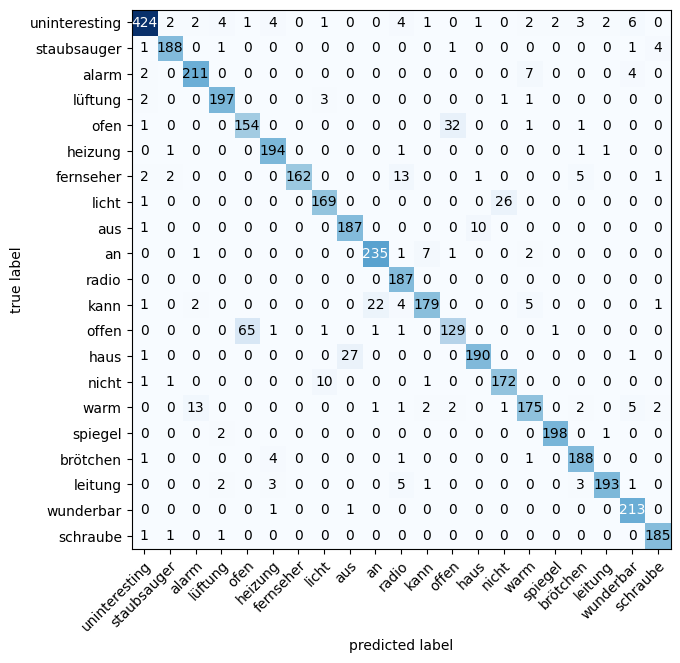

In [15]:
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classes.CLASSES), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_true_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=classes.CLASSES, # turn the row and column labels into class names
    figsize=(10, 7)
);